<a href="https://colab.research.google.com/github/piaseckazaneta/CV/blob/master/theEnergyStarScore_project_part_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

We will use the standard data science and machine learning libraries: numpy, pandas, and scikit-learn. We also use matplotlib and seaborn for visualization.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

The objective is to use the energy data to build a model that can predict the Energy Star Score of a building and interpret the results to find the factors which influence the score.

The data includes the Energy Star Score, which makes this a supervised regression machine learning task:

Supervised: we have access to both the features and the target and our goal is to train a model that can learn a mapping between the two
Regression: The Energy Star score is a continuous variable

We want to develop a model that is both accurate — it can predict the Energy Star Score close to the true value — and interpretable — we can understand the model predictions. Once we know the goal, we can use it to guide our decisions as we dig into the data and build models.

1. Data Cleaning
Real-world data is messy which means we need to clean and wrangle it into an acceptable format before we can even start the analysis. Data cleaning is an un-glamorous, but necessary part of most actual data science problems.

In [2]:
#1.1. Import libraries

import pandas as pd
import numpy as np

#1.2. # Read in data into a dataframe

data = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

data.head()



,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

This is a subset of the full data which contains 60 columns. Already, we can see a couple issues: first, we know that we want to predict the ENERGY STAR Score but we don’t know what any of the columns mean. While this isn’t necessarily an issue — we can often make an accurate model without any knowledge of the variables — we want to focus on interpretability, and it might be important to understand at least some of the columns.

When I originally got the assignment from the start-up, I didn’t want to ask what all the column names meant, so I looked at the name of the file,


and decided to search for “Local Law 84”. That led me to this page which explains this is an NYC law requiring all buildings of a certain size to report their energy use.

More searching brought me to all the definitions of the columns. Maybe looking at a file name is an obvious place to start, but for me this was a reminder to go slow so you don’t miss anything important!

We don’t need to study all of the columns, but we should at least understand the Energy Star Score, which is described as:

A 1-to-100 percentile ranking based on self-reported energy usage for the reporting year. The Energy Star score is a relative measure used for comparing the energy efficiency of buildings.

That clears up the first problem, but the second issue is that missing values are encoded as “Not Available”. This is a string in Python which means that even the columns with numbers will be stored as object datatypes because Pandas converts a column with any strings into a column of all strings. We can see the datatypes of the columns using the dataframe.info()method:

In [3]:
# See the column data types and non-missing values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

Sure enough, some of the columns that clearly contain numbers (such as ft²), are stored as objects. We can’t do numerical analysis on strings, so these will have to be converted to number (specifically float) data types!

Here’s a little Python code that replaces all the “Not Available” entries with not a number ( np.nan), which can be interpreted as numbers, and then converts the relevant columns to the float datatype:

In [4]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

In [5]:
# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11735 non-null  object 
 7   NYC Building Identification Number (BIN)                    11584 non-null  object 
 

Once the correct columns are numbers, we can start to investigate the data.

Missing Data and Outliers
In addition to incorrect datatypes, another common problem when dealing with real-world data is missing values. These can arise for many reasons and have to be either filled in or removed before we train a machine learning model. First, let’s get a sense of how many missing values are in each column (see the notebook for code).

Now that we have the correct column datatypes, we can start analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.

In [7]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
         # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


While we always want to be careful about removing information, if a column has a high percentage of missing values, then it probably will not be useful to our model. The threshold for removing columns should depend on the problem (here is a discussion), and for this project, we will remove any columns with more than 50% missing values.

At this point, we may also want to remove outliers. These can be due to typos in data entry, mistakes in units, or they could be legitimate but extreme values. For this project, we will remove anomalies based on the definition of extreme outliers:

Below the first quartile − 3 ∗ interquartile range
Above the third quartile + 3 ∗ interquartile range

In [9]:
# Get the columns with > 50% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [10]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

# For older versions of pandas (https://github.com/pandas-dev/pandas/issues/19078)
# data = data.drop(list(missing_columns), axis = 1)

The rest of the missing values will have to be imputed (filled-in) using an appropriate strategy before doing machine learning.

### **EKSPLORATORY DATA ANALYSIS  (EDA)**

 Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

In short, the goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find interesting parts of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

EDA  is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.

To begin the EDA, we will focus on a single variable, the Energy Star Score, because this is the target for our machine learning models. We can rename the column to score for simplicity and then start exploring this value.

2.1 Single Variable Plots

The goal is to predict the Energy Star Score (renamed to score in our data) so a reasonable place to start is examining the distribution of this variable. A histogram is a simple yet effective way to visualize the distribution of a single variable and is easy to make using matplotlib.

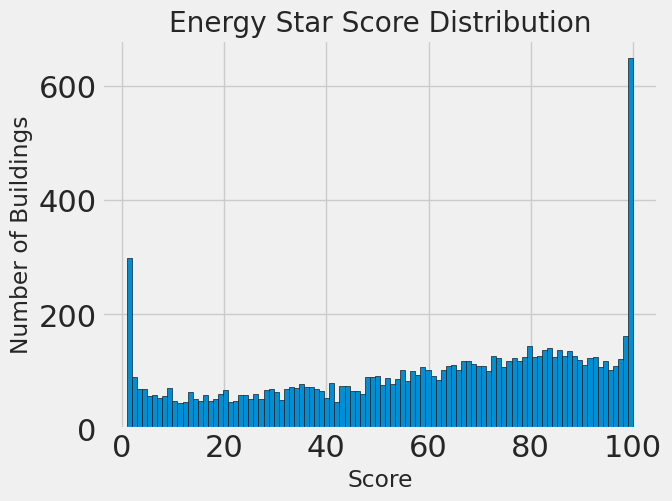

In [11]:
# Rename the score
data = data.rename(columns={'ENERGY STAR Score' : 'score'})

import matplotlib.pyplot as plt

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('Energy Star Score Distribution');

2.2. Looking for Relationships

A major part of EDA is searching for relationships between the features and the target. Variables that are correlated with the target are useful to a model because they can be used to predict the target. One way to examine the effect of a categorical variable (which takes on only a limited set of values) on the target is through a density plot using the seaborn library.

A density plot can be thought of as a smoothed histogram because it shows the distribution of a single variable. We can color a density plot by class to see how a categorical variable changes the distribution. The following code makes a density plot of the Energy Star Score colored by the the type of building (limited to building types with more than 100 data points):

In [12]:
# Create a list of buildings with more than 100 measurements
types = data.dropna(subset='score')
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values> 100].index)

# Plot of distribution of scores for building categories
figsize(12, 10)

<ipython-input-13-44df6b1ea53a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['score'].dropna(),
<ipython-input-13-44df6b1ea53a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['score'].dropna(),
<ipython-input-13-44df6b1ea53a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['score'].dropna(),
<ipython-input-13-44df6b1ea53a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset['score'].dropna(),


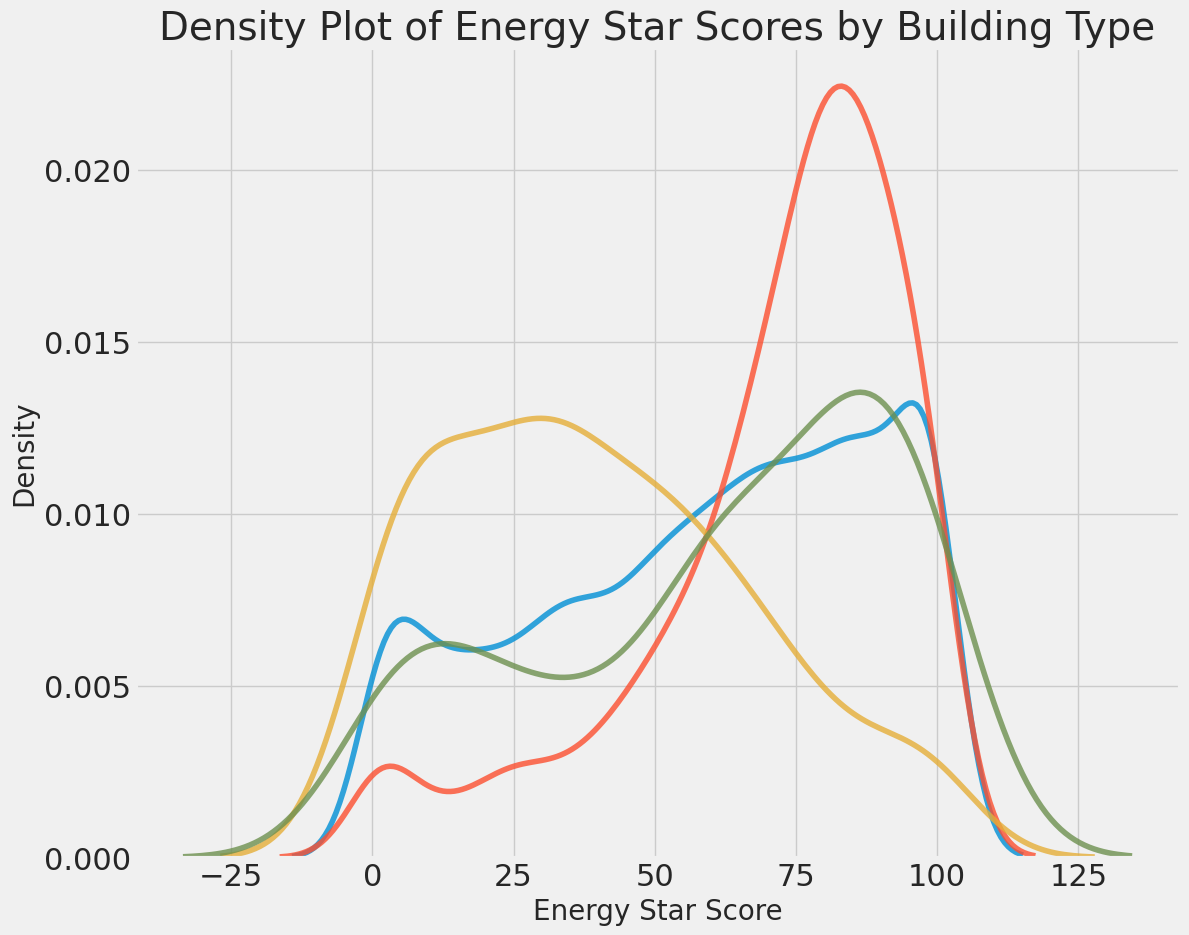

In [13]:
# Plot each building
for b_type in types:
  #Select the building type
 subset = data[data['Largest Property Use Type'] == b_type]

  # Density plot of Energy Star scores
 sns.kdeplot(subset['score'].dropna(),
              label = b_type, shade = False, alpha = 0.8)

# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20);
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

We can see that the building type has a significant impact on the Energy Star Score. Office buildings tend to have a higher score while Hotels have a lower score. This tells us that we should include the building type in our modeling because it does have an impact on the target. As a categorical variable, we will have to one-hot encode the building type.

A similar plot can be used to show the Energy Star Score by borough:

In [14]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

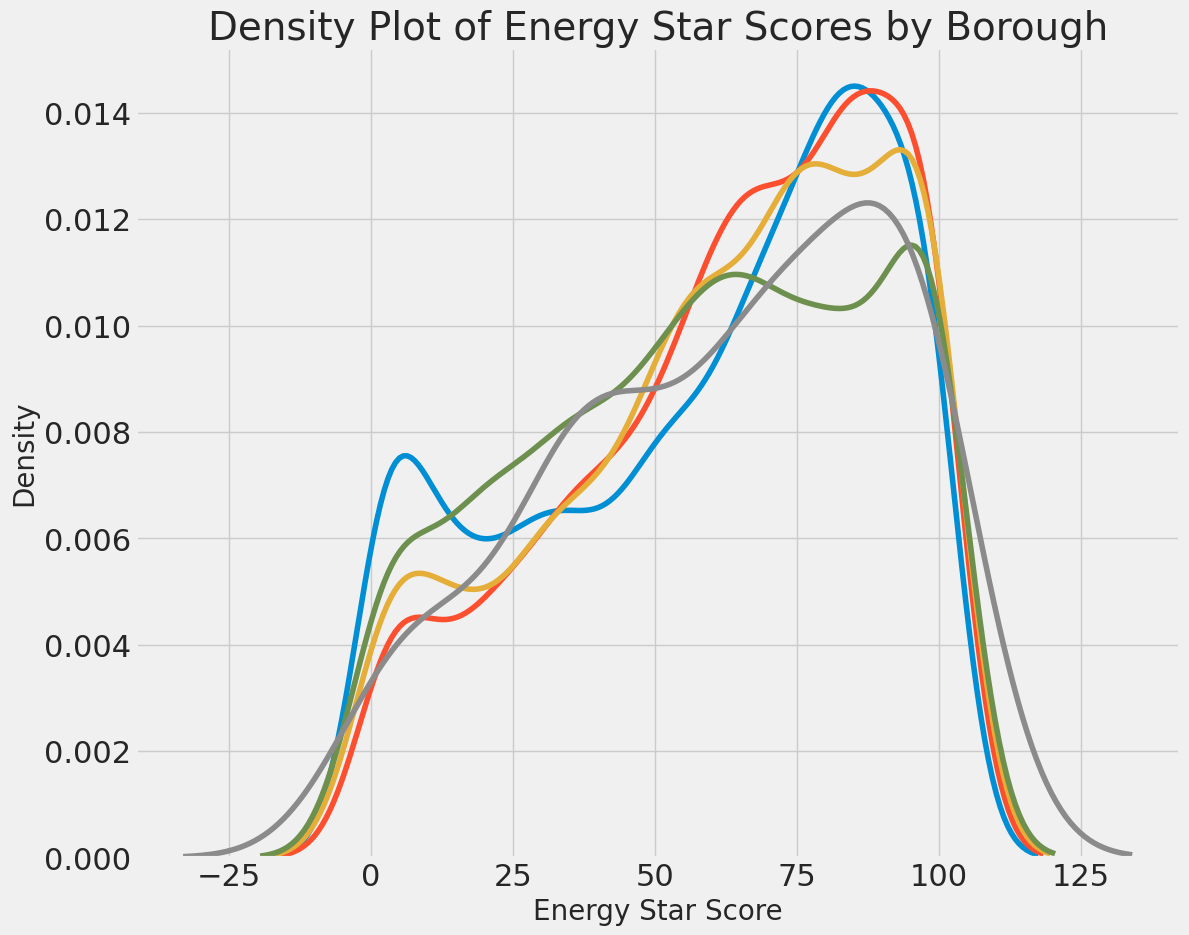

In [15]:
# Plot of distribution of scores for boroughs
figsize(12, 10)

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]

    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);

# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20);
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

The borough of the building does not seem to make as significant a difference in the distribution of the score as does the building type. Nonetheless, it might make sense to include the borough as a categorical variable.

### Correlations between Features and Target

n order to quantify correlations between the features (variables) and the target, we can calculate the Pearson correlation coefficient. This is a measure of the strength and direction of a linear relationship between two variables: a value of -1 means the two variables are perfectly negatively linearly correlated and a value of +1 means the two variables are perfectly positively linearly correlated. The figure below shows different values of the correlation coeffient and how they appear graphically.



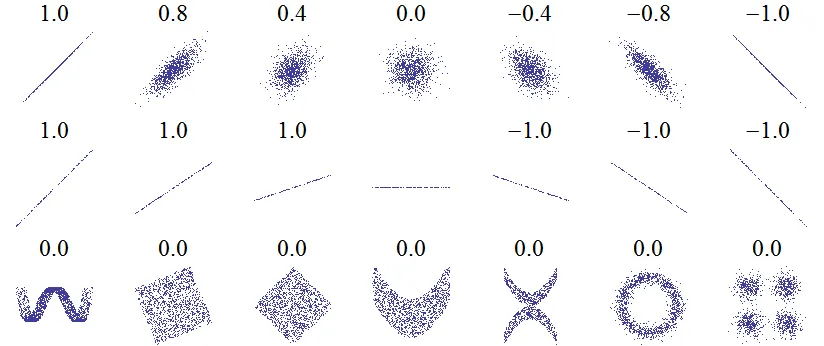

While the correlation coefficient cannot capture non-linear relationships, it is a good way to start figuring out how variables are related. In Pandas, we can easily calculate the correlations between any columns in a dataframe:

In [16]:
# Find all correlations with the score and sort
correlations_data = data.corr(numeric_only=True)['score'].sort_values()

In [17]:
# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Year Built                                                -0.118181
Weather Normalized Site Electricity Intensity (kWh/ft²)   -0.067762
Electricity Use - Grid Purchase (kBtu)                    -0.066330
Weather Normalized Site Electricity (kWh)                 -0.065789
Total GHG Emissions (Metric Tons CO2e)                    -0.047934
Property Id                                               -0.047020
Latitude                                                  -0.044262
Source EUI (kBtu/ft²)                                     -0.042873
Weather Normalized Source EUI (kBtu/ft²)                  -0.040913
Indirect GHG Emissions (Metric Tons CO2e)                 -0.040326
Site EUI (kBtu/ft²)                                       -0.036123
Weather Normalized Site EUI (kBtu/ft²)                    -0.035227
Occupancy                                                 -0.031116
Longitude                                                 -0.029670
Direct GHG Emissions (Metric Tons CO2e)         

**To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score.** To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.

In the following code, we take log and square root transformations of the numerical variables, one-hot encode the two selected categorical variables (building type and borough), calculate the correlations between all of the features and the score, and display the top 15 most positive and top 15 most negative correlations. This is a lot, but with pandas, it is straightforward to do each step!

In [18]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['score'])

# Find correlations with the score
correlations = features.corr()['score'].dropna().sort_values()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

In [19]:
# Display most negative correlations
correlations.head(15)

,score
log_Source EUI (kBtu/ft²),-0.607204
log_Site EUI (kBtu/ft²),-0.604309
log_Weather Normalized Source EUI (kBtu/ft²),-0.601330
log_Weather Normalized Site EUI (kBtu/ft²),-0.592217
log_Weather Normalized Site Electricity Intensity (kWh/ft²),-0.439732
log_Total GHG Emissions (Metric Tons CO2e),-0.376263
log_Direct GHG Emissions (Metric Tons CO2e),-0.292434
log_Indirect GHG Emissions (Metric Tons CO2e),-0.274698
sqrt_Weather Normalized Site Electricity Intensity (kWh/ft²),-0.274334
log_Weather Normalized Site Natural Gas Intensity (therms/ft²),-0.271061


In [20]:
# Display most positive correlations
correlations.tail(15)

,score
log_Property GFA - Self-Reported (ft²),0.024727
Borough_Queens,0.027145
log_Largest Property Use Type - Gross Floor Area (ft²),0.030102
sqrt_Order,0.034111
Largest Property Use Type_Residence Hall/Dormitory,0.035140
Order,0.039524
Borough_Brooklyn,0.052946
Council District,0.063185
sqrt_Council District,0.063197
log_Community Board,0.063430


After transforming the features, the strongest relationships are still those related to Energy Use Intensity (EUI). The log and square root transformations do not seem the have resulted in any stronger relationships. There are no strong positive linear relationships although we do see that a building type of office (Largest Property Use Type_Office) is slightly positively correlated with the score. This variable is a one-hot encoded representation of the categorical variables for building type.

We can use these correlations in order to perform feature selection (coming up in a little bit). Right now, let's graph the most significant correlation (in terms of absolute value) in the dataset which is Site EUI (kBtu/ft^2). We can color the graph by the building type to show how that affects the relationship.

Two-Variable Plots - WYSKAKUJE MI BŁAD!!! DO WERYFIKACJI

In order to visualize the relationship between two variables, we use a scatterplot. We can also include additional variables using aspects such as color of the markers or size of the markers. Here we will plot two numeric variables against one another and use color to represent a third categorical variable.

In [21]:
#figsize(12, 10)

# Extract the building types
#features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Limit to building types with more than 100 observations (from previous code)
#features = features[features['Largest Property Use Type'].isin(types)]

# Use seaborn to plot a scatterplot of Score vs Log Source EUI
#sns.lmplot('Site EUI (kBtu/ft²)', 'score',
          #hue = 'Largest Property Use Type', data = features,
         # scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          #size = 12, aspect = 1.2);

# Plot labeling
##plt.xlabel("Site EUI", size = 28)
#plt.ylabel('Energy Star Score', size = 28)
#plt.title('Energy Star Score vs Site EUI', size = 36);

## Pairs Plot

As a final exercise for exploratory data analysis, we can make a pairs plot between several different variables. **The Pairs Plot is a great way to examine many variables at once** as it shows scatterplots between pairs of variables and histograms of single variables on the diagonal.

Using the seaborn PairGrid function, we can map different plots on to the three aspects of the grid. The upper triangle will have scatterplots, the diagonal will show histograms, and the lower triangle will show both the correlation coefficient between two variables and a 2-D kernel density estimate of the two variables.

In [22]:
# Extract the columns to  plot
plot_data = features[['score', 'Site EUI (kBtu/ft²)',
                      'Weather Normalized Source EUI (kBtu/ft²)',
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

In [23]:
# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})


In [24]:
# Rename columns
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI',
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

In [25]:
# Drop NA values
plot_data = plot_data.dropna()


In [26]:
# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

ValueError: Contour levels must be increasing

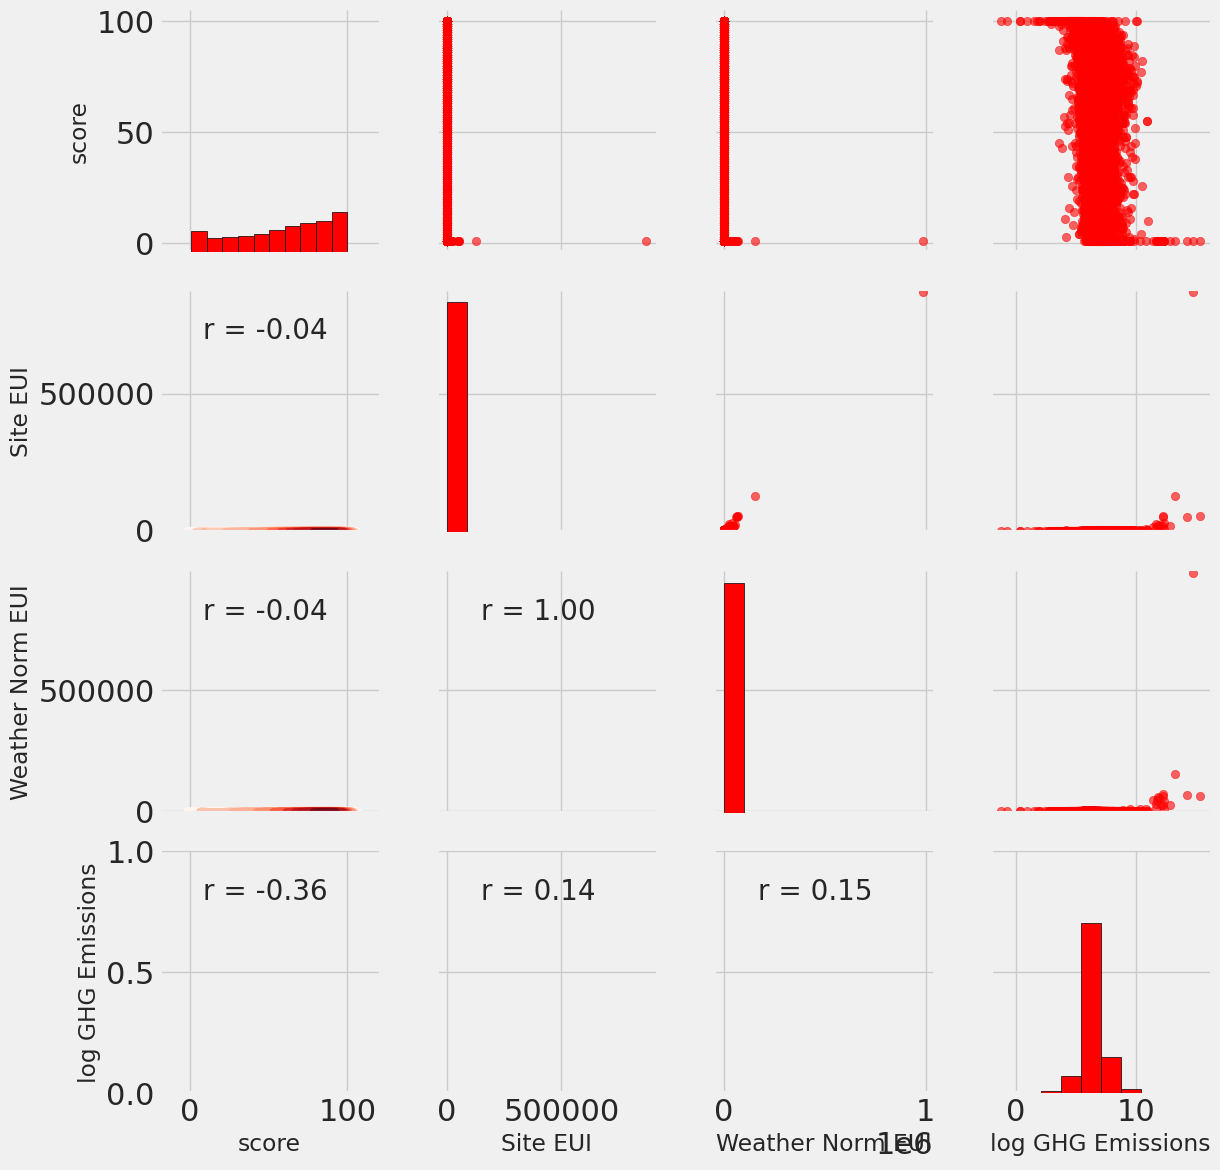

In [27]:
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

To interpret the relationships in the plot, we can look for where the variables in one row intersect with the variables in one column. For example, to find the relationship between score and the log of GHG Emissions, we look at the score column and find the log GHG Emissions row. At the intersection (the lower left plot) we see that the score has a -0.35 correlation coefficient with this varible. If we look at the upper right plot, we can see a scatterplot of this relationship.

### Feature Engineering and Selection

Now that we have explored the trends and relationships within the data, we can work on engineering a set of features for our models. We can use the results of the EDA to inform this feature engineering. In particular, we learned the following from EDA which can help us in engineering/selecting features:

The score distribution varies by building type and to a lesser extent by borough. Although we will focus on numerical features, we should also include these two categorical features in the model.
Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score

Before we get any further, we should define what feature engineering and selection are! These definitions are informal and have considerable overlap, but I like to think of them as two separate processes:

Feature Engineering: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as adding additional features derived from the raw data.
Feature Selection: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the most variance. In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as subtracting features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

Feature engineering and selection often has the highest returns on time invested in a machine learning problem. It can take quite a while to get right, but is often more important than the exact algorithm and hyperparameters used for the model. If we don't feed the model the correct data, then we are setting it up to fail and we should not expect it to learn!

In this project, we will take the following steps for feature engineering:

Select only the numerical variables and two categorical variables (borough and property use type)
Add in the log transformation of the numerical variables
One-hot encode the categorical variables
For feature selection, we will do the following:

Remove collinear features
We will discuss collinearity (also called multicollinearity) when we get to that process!

The following code selects the numeric features, adds in log transformations of all the numeric features, selects and one-hot encodes the categorical features, and joins the sets of features together.

In [ ]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

At this point, we have 11746 observations (buildings) with 114 different features (one column is the score). Not all of these features are likely to be important for predicting the score, and several of these features are also redundant because they are highly correlated. We will deal with this second issue below.

### Remove Collinear Features

Highly collinear features have a significant correlation coefficent between them. For example, in our dataset, the Site EUI and Weather Norm EUI are highly correlated because they are just slightly different means of calculating the energy use intensity.

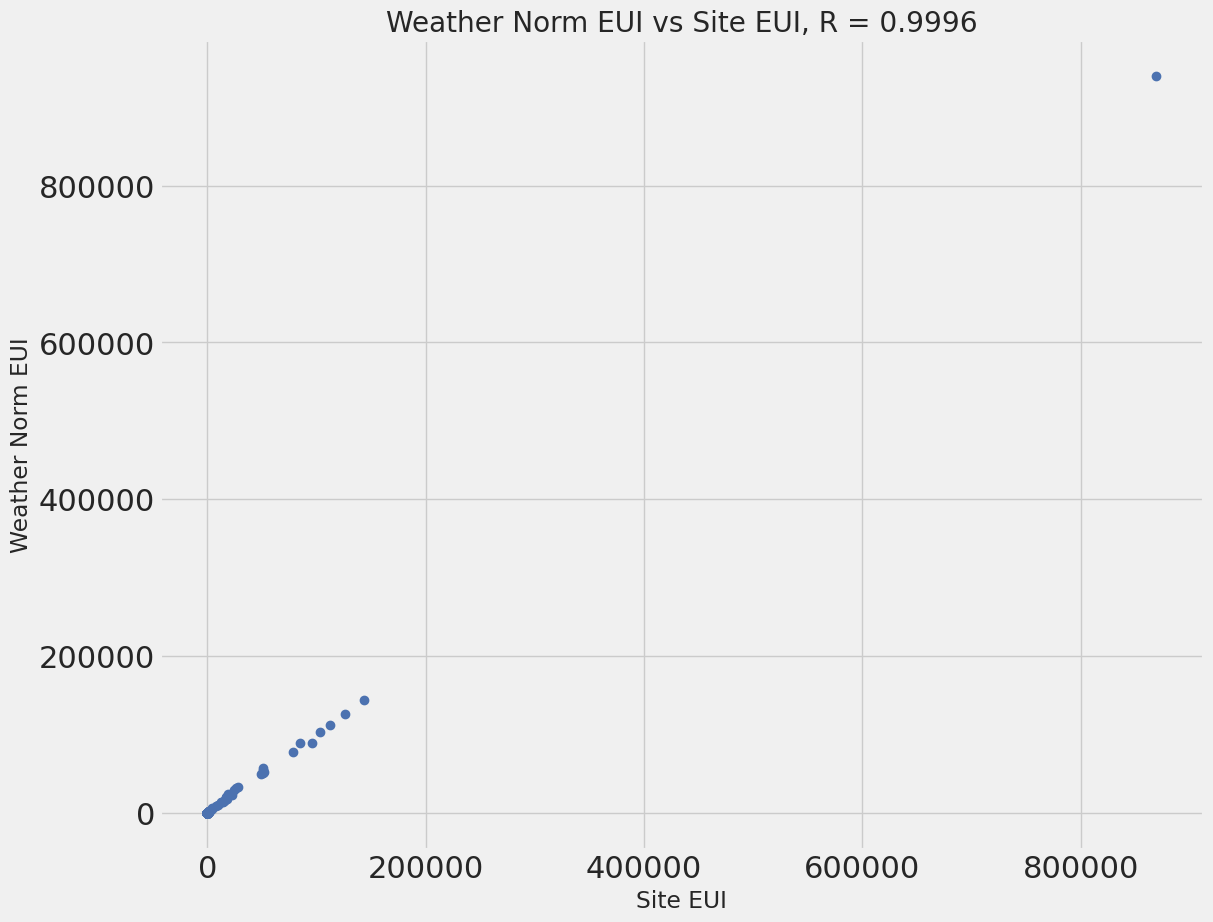

In [31]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

While variables in a dataset are usually correlated to a small degree, highly collinear variables can be redundant in the sense that we only need to retain one of the features to give our model the necessary information.

Removing collinear features is a method to reduce model complexity by decreasing the number of features and can help to increase model generalization. It can also help us to interpret the model because we only have to worry about a single variable, such as EUI, rather than how both EUI and weather normalized EUI affect the score.

There are a number of methods for removing collinear features, such as using the Variance Inflation Factor. We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other (not with the score because we want variables that are highly correlated with the score!) For a more thorough discussion of removing collinear variables, check out this notebook on Kaggle.

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value.

Again, I did not actually write this code from scratch, but rather adapted it from a Stack Overflow answer

In [32]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        threshold: any features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    # Dont want to remove correlations between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)',
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])

    # Add the score back in to the data
    x['score'] = y

    return x

In [33]:
# Remove the collinear features above a specified correlation coefficient
features = remove_collinear_features(features, 0.6);

In [34]:
# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape

(9642, 72)

Our final dataset now has 64 features (one of the columns is the target). This is still quite a few, but mostly it is because we have one-hot encoded the categorical variables. Moreover, while a large number of features may be problematic for models such as linear regression, models such as the random forest perform implicit feature selection and automatically determine which features are important during traning. There are other feature selection steps to take, but for now we will keep all the features we have and see how the model performs.

Additional Feature Selection

There are plenty of more methods for feature selection. Some popular methods include principal components analysis (PCA) which transforms the features into a reduced number of dimensions that preserve the greatest variance, or independent components analysis (ICA) which aims to find the independent sources in a set of features. However, while these methods are effective at reducing the number of features, they create new features that have no physical meaning and hence make interpreting a model nearly impossible.

These methods are very helpful for dealing with high-dimensional data and I would suggest reading more on the topic if you plan on dealing with machine learning problems!

### Split Into Training and Testing Sets

In machine learning, we always need to separate our features into two sets:

**Training set** which we provide to our model during training along with the answers so it can learn a mapping between the features and the target.
**Testing set** which we use to evaluate the mapping learned by the model. The model has never seen the answers on the testing set, but instead, must make predictions using only the features. As we know the true answers for the test set, we can then compare the test predictions to the true test targets to get an estimate of how well our model will perform when deployed in the real world.
For our problem, we will first extract all the buildings without an Energy Star Score (we don't know the true answer for these buildings so they will not be helpful for training or testing). Then, we will split the buildings with an Energy Star Score into a testing set of 30% of the buildings, and a training set of 70% of the buildings.

Splitting the data into a random training and testing set is simple using scikit-learn. We can set the random state of the split to ensure consistent results.

In [35]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(0, 72)
(9642, 72)


In [36]:
# Separate out the features and targets
features = score.drop(columns='score') # W celu otrzymania features po prostu wycinamy target 'score'
targets = pd.DataFrame(score['score']) # W celu otrzymania targetu, tworzymy nową ramkę danych tylko ze 'score'

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6749, 71)
(2893, 71)
(6749, 1)
(2893, 1)


We have 0 buildings with no score, 6749 buildings with a score in the training set, and 2893 buildings with a score in the testing set.

We have one final step to take in this notebook: determining a naive baseline for our models to beat!

### Establish a Baseline

It's important to establish a naive baseline before we beginning making machine learning models. If the models we build cannot outperform a naive guess then we might have to admit that machine learning is not suited for this problem. This could be because we are not using the right models, because we need more data, or because there is a simpler solution that does not require machine learning. Establishing a baseline is crucial so we do not end up building a machine learning model only to realize we can't actually solve the problem.

For a regression task, a good naive baseline is to predict the median value of the target on the training set for all examples on the test set. This is simple to implement and sets a relatively low bar for our models: if they cannot do better than guessing the medin value, then we will need to rethink our approach.

In [37]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [38]:
#Now we can make the median guess and evaluate it on the test set.

baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 65.00
Baseline Performance on the test set: MAE = 25.3519


This shows our average estimate on the test set is off by about 25 points. The scores are between 1 and 100 so this means the average error from a naive method if about 25%. The naive method of guessing the median training value provides us a low baseline for our models to beat!

Conclusions
In this notebook, we carried out the first three steps of a machine learning problem:

Cleaned and formatted the raw data
Performed an exploratory data analysis
Developed a set of features to train our model using feature engineering and feature selection
We also completed the crucial task of establishing a baseline metric so we can determine if our model is better than guessing!

Hopefully, you are starting to get a sense of how each part of the pipeline flows into the next: cleaning the data and getting it into the proper format allows us to perform an exploratory data analyis. The EDA then informs our decisions in the feature engineering and selection stage. These three steps generally are performed in this order, although we may come back later and do more EDA or feature engineering based on our modeling results. Data science is an iterative process in which we are always looking for ways to improve our previous work. This means we do not have to get things perfect the first time (although we can try our best) because there are almost always opportunities to revisit our decisions once we know more about the problem.

In part two, we will focus on implementing several machine learning methods, selecting the best model, and optimizing it for our problem using hyperparameter tuning with cross validation. As a final step here, we will save the datasets we developed to use again in the next part.

In [39]:
# Save the no scores, training, and testing data
no_score.to_csv('no_score.csv', index = False)
X.to_csv('training_features.csv', index = False)
X_test.to_csv('testing_features.csv', index = False)
y.to_csv('training_labels.csv', index = False)
y_test.to_csv('testing_labels.csv', index = False)